In [1]:
# Actualizamos los módulos automáticamente
%reload_ext autoreload
%autoreload 2

# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas import json_normalize
import json
import sys
import os

# Añadir el directorio scripts al PYTHONPATH
sys.path.append(os.path.abspath("../scripts"))

# Importamos funciones personalizadas
import funciones

# Rutas
ruta_user_items = '../data/user_items.parquet'
ruta_user_info = '../data/user_info.parquet'

# Rutas para recuperar backups
ruta_user_items_backup = '../backup/user_items.parquet'

# Carga de datos
user_items_df = pd.read_parquet(ruta_user_items)
user_info_df = pd.read_parquet(ruta_user_info)

In [19]:
# Dimensiones iniciales
user_items_df.shape

(88310, 5)

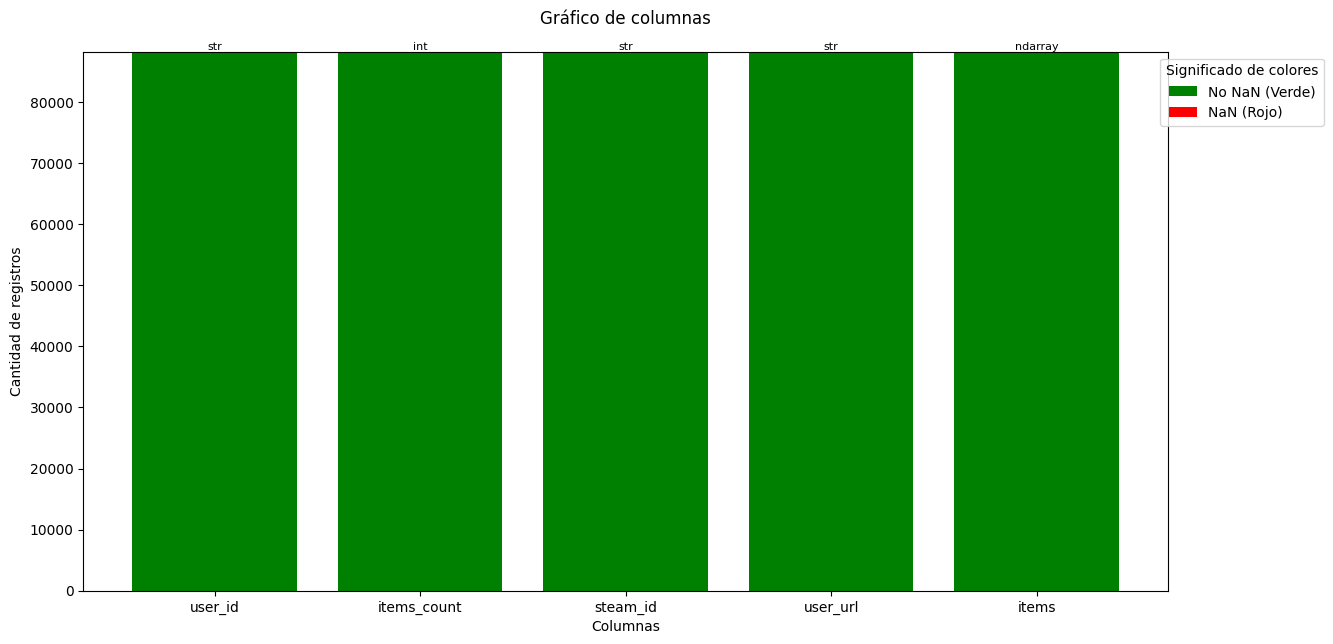

In [20]:
# Visualización inicial
funciones.plot_df_info(user_items_df)

In [21]:
# Pasamos la columna items a tipo de dato lista para poder manipularla luego en la desanidación:
user_items_df['items'] = user_items_df['items'].apply(lambda x: x.tolist())

In [76]:
'''
Observamos un campo o columna que tiene datos anidados, que con un explode podríamos generar una tabla nueva con esa infromación,
pero antes vamos a explorar la posibilidad, y siendo que no existen datos nulos, que haya datos duplicados, si bien no podremos
hacer nada con ello hasta despues del explode, debido a que analizar registro por registro nos haria tener que iterar la columna,
accion que con el explode igualmente deberiamos hacer, solo que va a ser mucho mas comodo iterar sobre columnas, que sobre una 
columna con arrays, y dentro de los arrays.
'''

'\nObservamos un campo o columna que tiene datos anidados, que con un explode podríamos generar una tabla nueva con esa infromación,\npero antes vamos a explorar la posibilidad, y siendo que no existen datos nulos, que haya datos duplicados, si bien no podremos\nhacer nada con ello hasta despues del explode, debido a que analizar registro por registro nos haria tener que iterar la columna,\naccion que con el explode igualmente deberiamos hacer, solo que va a ser mucho mas comodo iterar sobre columnas, que sobre una \ncolumna con arrays, y dentro de los arrays.\n'

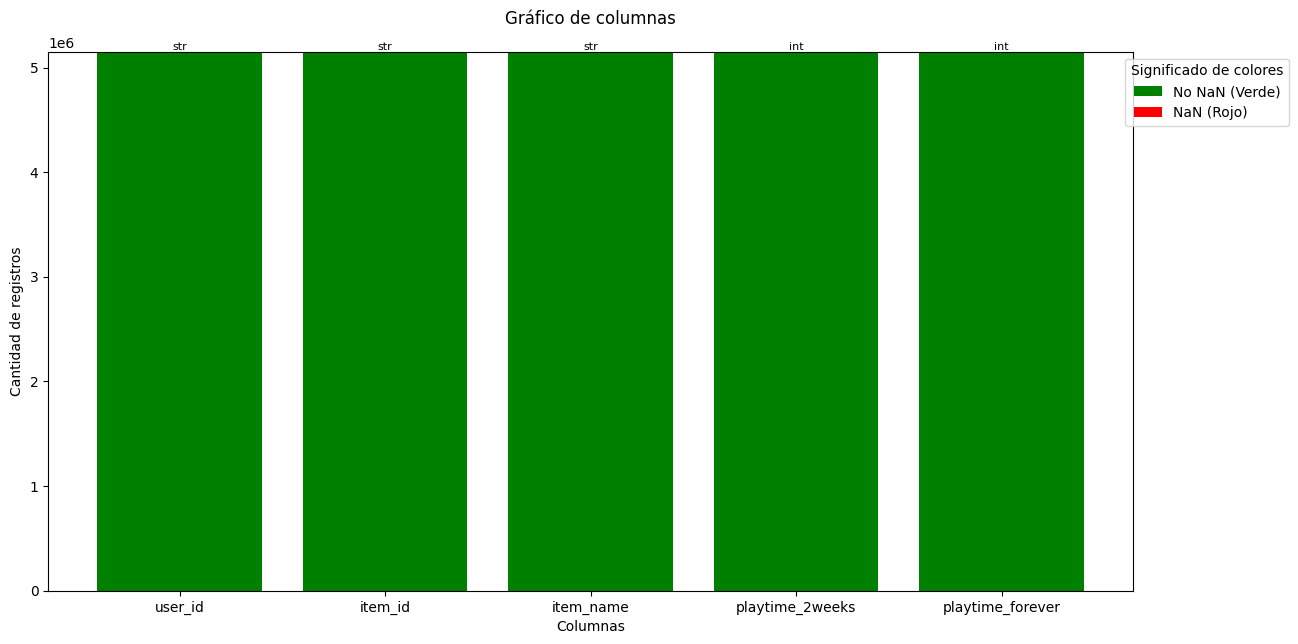

In [22]:
#explode
# Inicializar una lista para almacenar los registros expandidos
expanded_data = []

# Iterar sobre cada fila del DataFrame
for index, row in user_items_df.iterrows():
    items_list = row['items']
    
    # Verificar si la lista de items está vacía
    if items_list:
        user_id = row['user_id']

        # Iterar sobre cada diccionario en la lista de items
        for item_dict in items_list:
            
            # Crear un nuevo registro con el mismo user_id y los valores del diccionario
            new_record = {'user_id': user_id}
            new_record.update(item_dict)  # Agregar valores del diccionario al nuevo registro
            expanded_data.append(new_record)

# Crear un nuevo DataFrame a partir de los registros expandidos
exploded_df = pd.DataFrame(expanded_data)

funciones.plot_df_info(exploded_df)

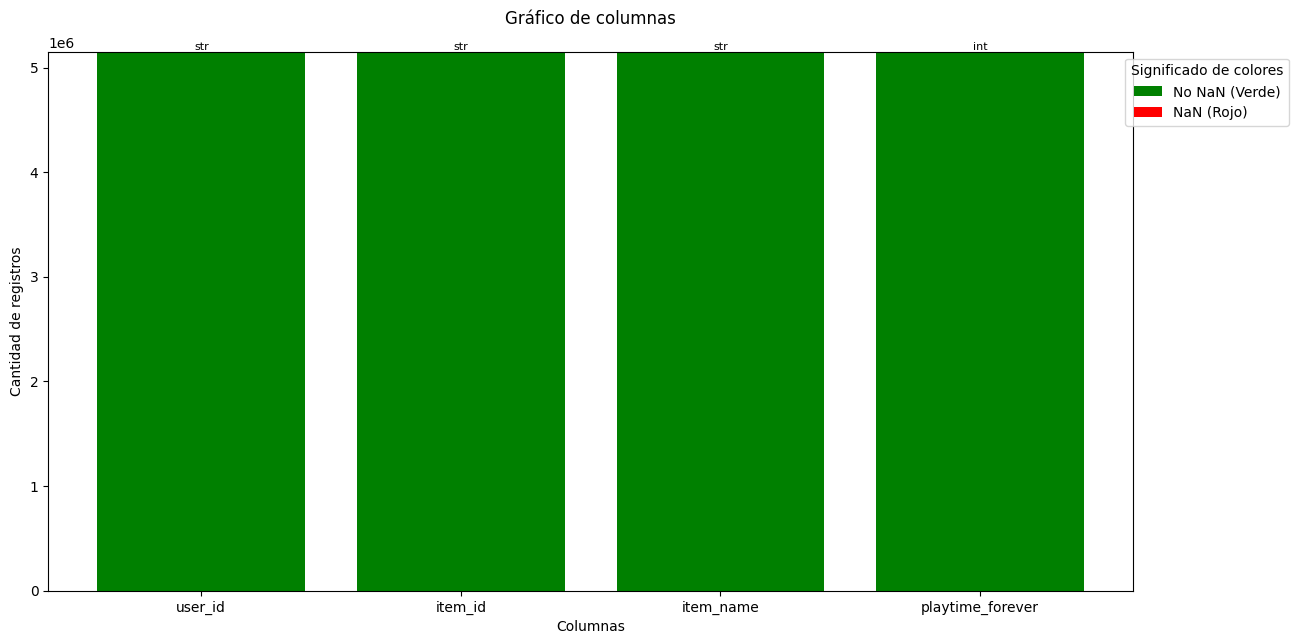

In [23]:
# Sabemos que para los endpoints que queremos plantear la columna playtime_2weeks no es necesaria: 
exploded_df = exploded_df.drop('playtime_2weeks', axis=1)

funciones.plot_df_info(exploded_df)

In [79]:
'''
comentario para seguir despues: Una vez gestado el explode, necesito verificar que la data obtenida es consistente. Vamos a generar una columna calculada a
partir de la columna items, que tenga en booleano o binario, false si la lista esta vacia, true en caso con  trario, luego borraremos la columna items y 
separaremos a los usuarios en 2, los que contenian al menos un item en la columna items, y los que no, y comprobaremos de ambos grupos si existen registros
con ese usuario en mi dataframe producto del explode, y todo estara en orden todos los del grupo true estan contenidos, y los de false ninguno. Luego 
eliminaremos duplicados de nuestro segundo df y haremos un count de las filas, que es el resultado a cuantos items hay en total, luego en mi primer df 
haremos un sum de la columna items_count y tiene que ser igual a la cantidad de filas de nuestro segundo df. De no ser consistente, tenemos que ver cuantos
usuarios con el mismo user_id hay, sin que necesariamente sea toda la fila duplicada, y agrupar nuestro df resultante por user_id, para ver si tenemos 
duplicados que no hayamos podido deshacernos previamente, y evaluar cual de los datos imputados es el correcto, tambien en el agrupamiento por user_id de 
nuestro segundo dataframe podriamos hacer un sum de los groups para ver cuantos items, sin repetir tiene el usuario, y buscar tambien si hay duplicados por
item_id
'''

'\ncomentario para seguir despues: Una vez gestado el explode, necesito verificar que la data obtenida es consistente. Vamos a generar una columna calculada a\npartir de la columna items, que tenga en booleano o binario, false si la lista esta vacia, true en caso con  trario, luego borraremos la columna items y \nsepararemos a los usuarios en 2, los que contenian al menos un item en la columna items, y los que no, y comprobaremos de ambos grupos si existen registros\ncon ese usuario en mi dataframe producto del explode, y todo estara en orden todos los del grupo true estan contenidos, y los de false ninguno. Luego \neliminaremos duplicados de nuestro segundo df y haremos un count de las filas, que es el resultado a cuantos items hay en total, luego en mi primer df \nharemos un sum de la columna items_count y tiene que ser igual a la cantidad de filas de nuestro segundo df. De no ser consistente, tenemos que ver cuantos\nusuarios con el mismo user_id hay, sin que necesariamente sea toda

In [24]:
# Creamos columna que comprueba si el usuario tiene al menos item registrado o no:
user_items_df['has_items'] = user_items_df['items'].apply(lambda x: True if x else False)

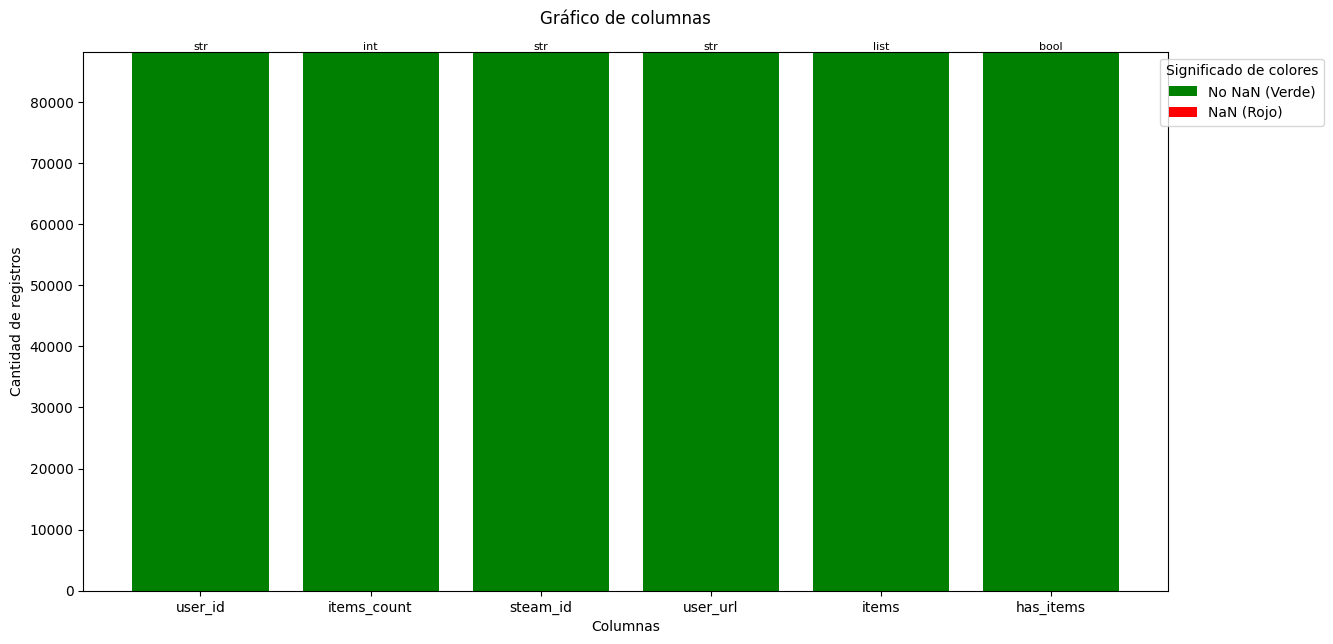

In [25]:
funciones.plot_df_info(user_items_df)

In [26]:
# Eliminamos columna items
user_items_df.drop(columns=['items'], inplace=True)

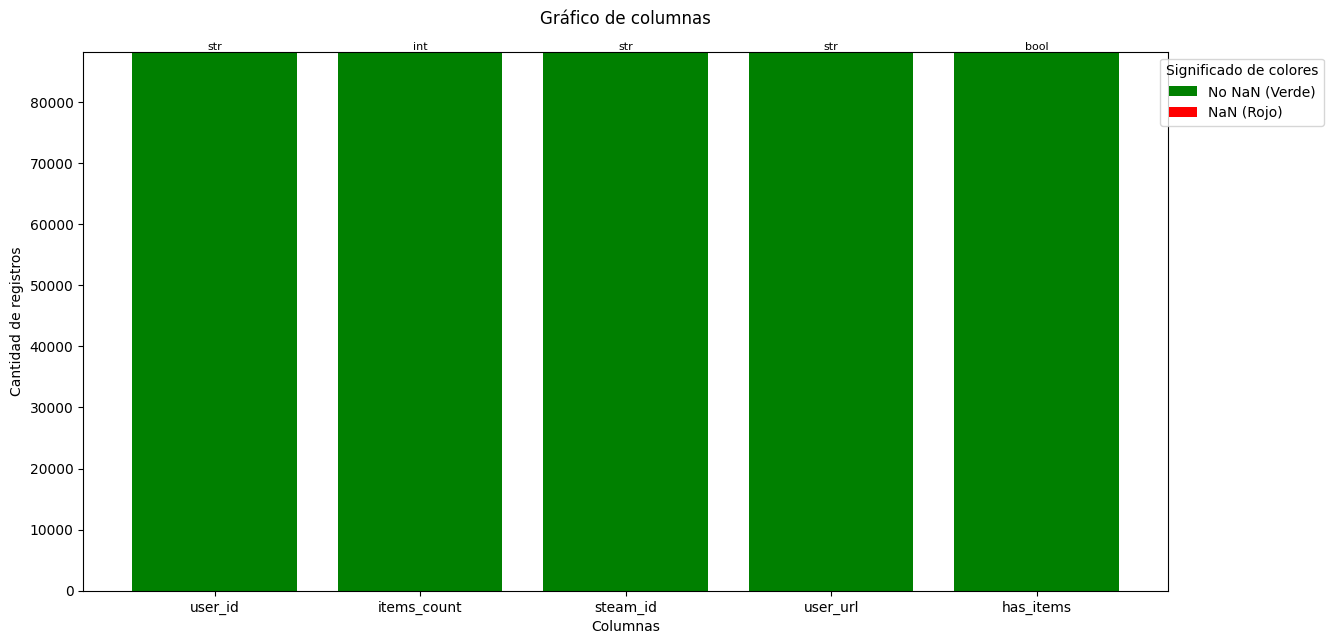

In [27]:
funciones.plot_df_info(user_items_df)

In [28]:
# Eliminamos registros duplicados de ambos dataframes y vemos la diferencia

print(f"dimenciones exploded_df antes del drop_duplicates{exploded_df.shape}")
exploded_df = exploded_df.drop_duplicates()
print(f"dimenciones exploded_df despues del drop_duplicates{exploded_df.shape}")

print(f"dimenciones exploded_df antes del drop_duplicates{user_items_df.shape}")
user_items_df = user_items_df.drop_duplicates()
print(f"dimenciones exploded_df despues del drop_duplicates{user_items_df.shape}")

dimenciones exploded_df antes del drop_duplicates(5153209, 4)
dimenciones exploded_df despues del drop_duplicates(5094092, 4)
dimenciones exploded_df antes del drop_duplicates(88310, 5)
dimenciones exploded_df despues del drop_duplicates(87626, 5)


In [29]:
# Pasamos datos vacios a NaN
user_items_df.replace(r'^\s*$', pd.NA, regex=True, inplace=True)
exploded_df.replace(r'^\s*$', pd.NA, regex=True, inplace=True)

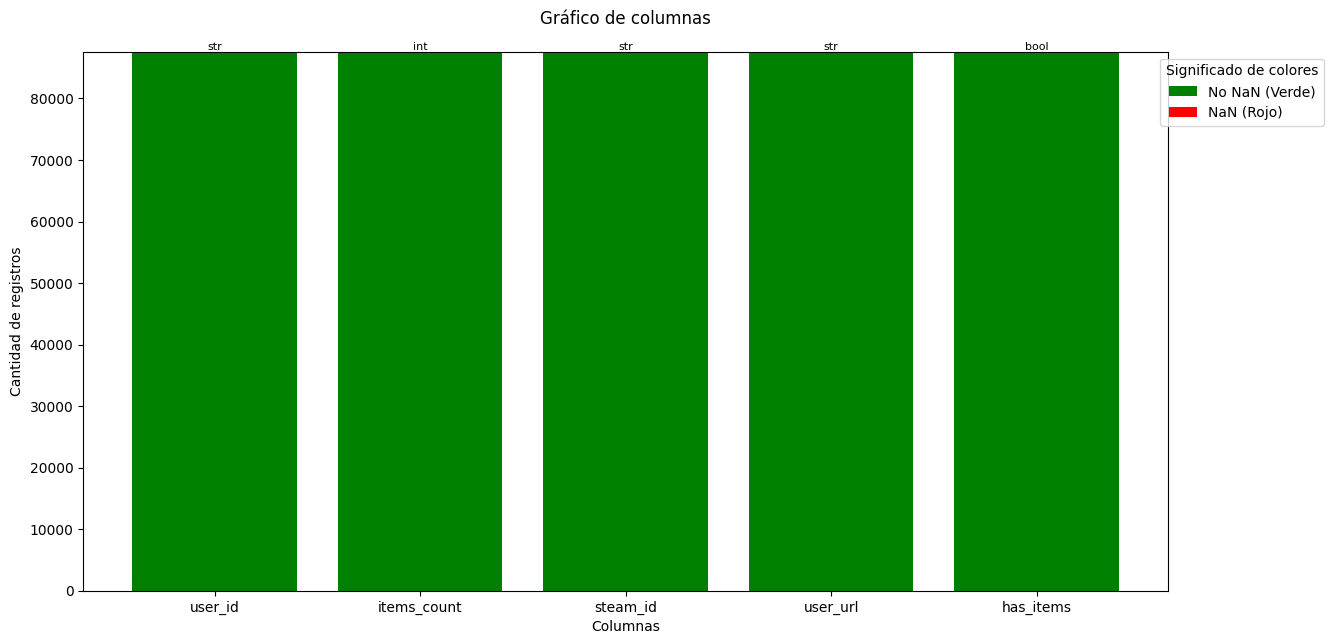

In [30]:
# Visualizamos a ver si hay algún cambio
funciones.plot_df_info(user_items_df)

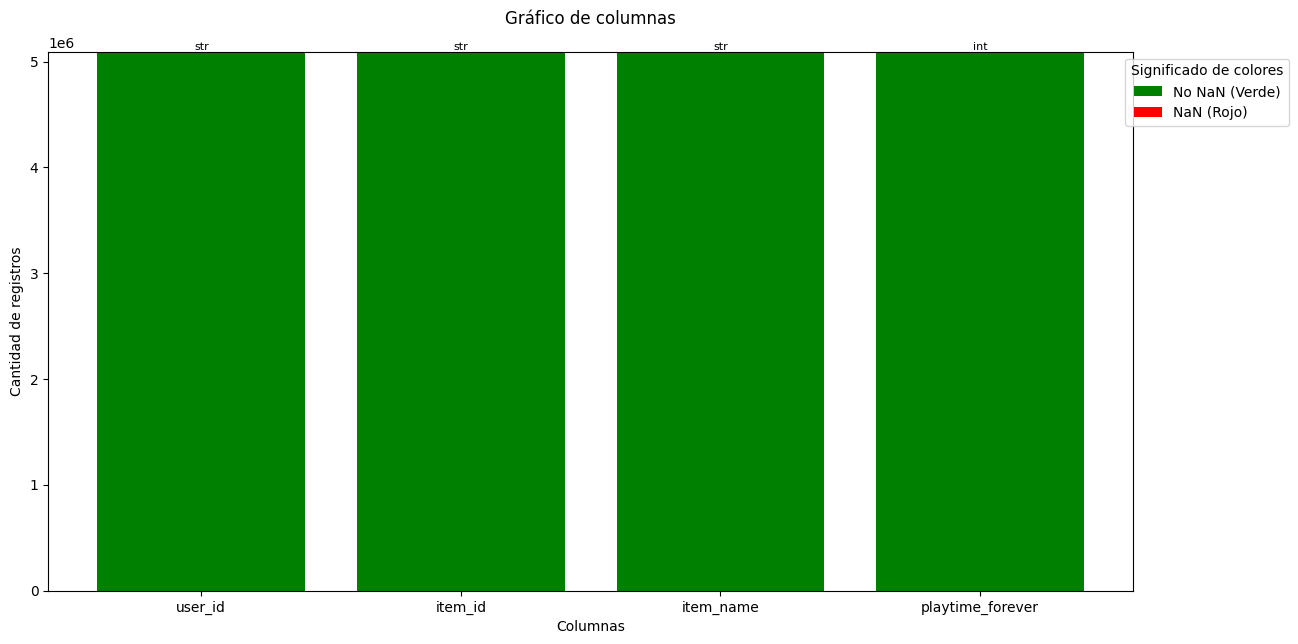

In [31]:
funciones.plot_df_info(exploded_df)

In [32]:
# Revision de consistencia I: user_id con has_items = False que se encuentren en exploded_df en la misma columna:

# Filtrar user_ids en user_items_df con has_items igual a False
user_ids_without_items = user_items_df[user_items_df['has_items'] == False]['user_id']

# Contar cuántos de esos user_id aparecen en exploded_df
repeated_user_ids_count = exploded_df[exploded_df['user_id'].isin(user_ids_without_items)]['user_id'].nunique()

# Mostrar el resultado
print("Cantidad de user_id en user_items_df con has_items=False que se repiten en exploded_df:", repeated_user_ids_count)


Cantidad de user_id en user_items_df con has_items=False que se repiten en exploded_df: 0


In [33]:
# Revisicón de consistencia II: registros duplicados por user_id pero con diferencia en sus columnas: 

# Contar los user_id únicos
unique_user_ids_count = user_items_df['user_id'].nunique()

# Contar el número total de registros
total_records_count = user_items_df.shape[0]

# Mostrar los resultados
print("Cantidad de user_id únicos en user_items_df:", unique_user_ids_count)
print("Cantidad total de registros en user_items_df:", total_records_count)

Cantidad de user_id únicos en user_items_df: 87626
Cantidad total de registros en user_items_df: 87626


In [90]:
"pareceria no haber problemas de duplicados en user_items_df"

'pareceria no haber problemas de duplicados en user_items_df'

In [34]:
# Revisicón de consistencia III: registros duplicados por user_id e item_id en exploded df:

# Identificar duplicados basados en las columnas user_id y item_id
duplicates = exploded_df.duplicated(subset=['user_id', 'item_id'])

# Contar el número de registros duplicados
duplicate_count = duplicates.sum()

# Mostrar el resultado
print("Cantidad de registros duplicados en exploded_df por las columnas user_id y item_id:", duplicate_count) 

Cantidad de registros duplicados en exploded_df por las columnas user_id y item_id: 10


In [35]:
# Identificar los registros duplicados basados en las columnas user_id y item_id
duplicates = exploded_df.duplicated(subset=['user_id', 'item_id'], keep=False)

# Filtrar los registros duplicados usando loc
duplicate_rows = exploded_df[duplicates]

# Mostrar los registros duplicados
print("Registros duplicados en exploded_df basados en las columnas user_id y item_id:")

# Ordenar los registros duplicados alfabéticamente
duplicate_rows_sorted = duplicate_rows.sort_values(by=['user_id', 'item_id'])

duplicate_rows_sorted

Registros duplicados en exploded_df basados en las columnas user_id y item_id:


,user_id,item_id,item_name,playtime_forever
399349,76561198050680344,377160,Fallout 4,1997
1507171,76561198050680344,377160,Fallout 4,2058
426991,76561198064956087,40100,Supreme Commander 2,2504
1578756,76561198064956087,40100,Supreme Commander 2,2543
54357,76561198072861800,433850,H1Z1: King of the Kill,5083
2104602,76561198072861800,433850,H1Z1: King of the Kill,5084
1556733,76561198079079942,282070,This War of Mine,1486
3404683,76561198079079942,282070,This War of Mine,1516
356693,76561198081666970,361600,Luna Sky,2
3201764,76561198081666970,361600,Luna Sky,9


In [36]:
# Cantidad de duplicados complejos
duplicate_rows_sorted.shape

(20, 4)

In [37]:
# Antes de eliminar estos duplicados vamos a ver cuantos duplicados deberian desaparecer, y cuantos registros hay:

# Contar los user_id únicos en duplicate_rows_sorted
unique_cases_count = duplicate_rows_sorted.drop_duplicates(subset=['user_id', 'item_id']).shape[0]

# Contar la cantidad total de registros en exploded_df
total_records_count = exploded_df.shape[0]

# Mostrar los resultados
print("Cantidad de casos únicos basados en user_id y item_id en duplicate_rows_sorted:", unique_cases_count)
print("Cantidad total de registros en exploded_df:", total_records_count)

Cantidad de casos únicos basados en user_id y item_id en duplicate_rows_sorted: 10
Cantidad total de registros en exploded_df: 5094092


In [38]:
# Procedemos a eliminar los duplicados por user_id y item_id con el maximo playtime_forever

# Encuentra los índices de los registros con el mayor valor en playtime_forever para cada grupo de user_id e item_id
indices_max = exploded_df.groupby(['user_id', 'item_id'])['playtime_forever'].idxmax()

# Filtra el DataFrame original usando los índices encontrados
exploded_df = exploded_df.loc[indices_max]

exploded_df.shape # deberian ser 10 registros menos que el count anterior 5094092

(5094082, 4)

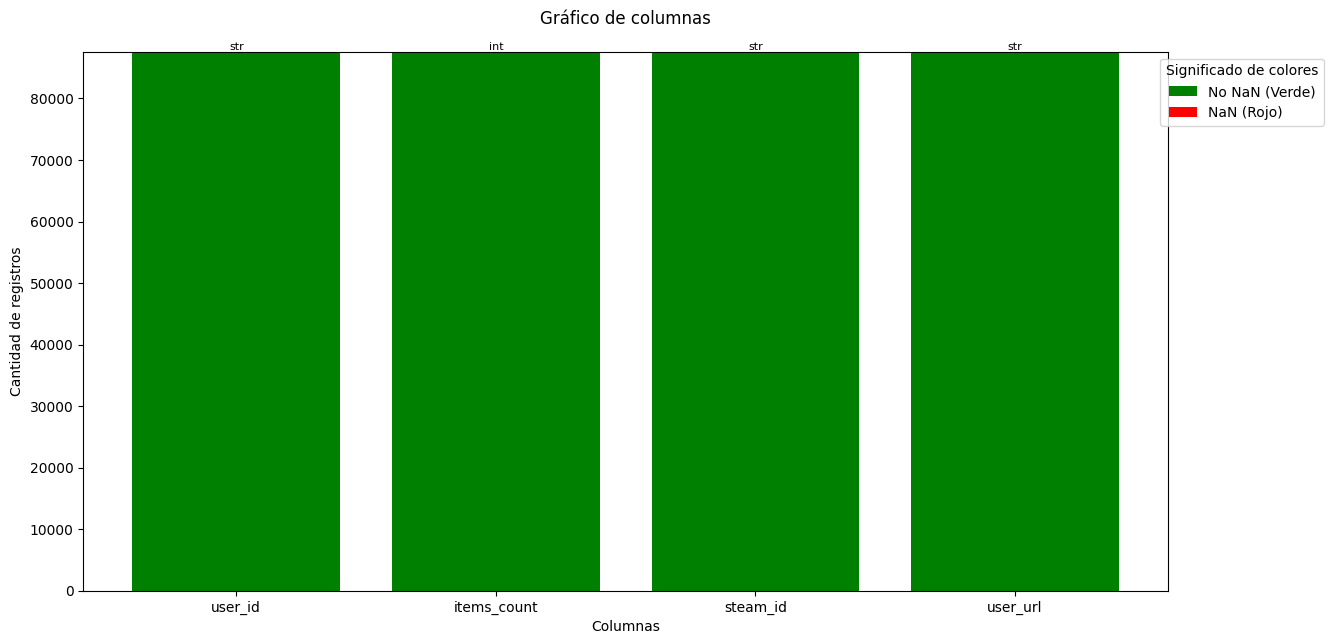

In [39]:
# Eliminamos columna has_items
user_items_df.drop(columns=['has_items'], inplace=True)
funciones.plot_df_info(user_items_df)

In [41]:
# La columna items_count tampoco la vamos a usar y a fin de ahorrar espacio:
user_items_df.drop(columns=['items_count'], inplace=True)

In [47]:
# Convertir el tipo de dato de item_id de str a int en user_items_df
exploded_df['item_id'] = exploded_df['item_id'].astype(int, errors='raise')

In [2]:
funciones.plot_df_info(exploded_df)

NameError: name 'funciones' is not defined

In [48]:
'''
Guardamos el dataframe exploded_df en user_items.parquet, porque allí van a estar los items, y a partir de user_items_df creamos
un nuevo parquet llamado user_info.parquet
'''

# Guardamos exploded_df en user_items.parquet
exploded_df.to_parquet(ruta_user_items, index=False)

# Guardamos user_items_df en user_info.parquet
user_items_df.to_parquet(ruta_user_info, index=False)

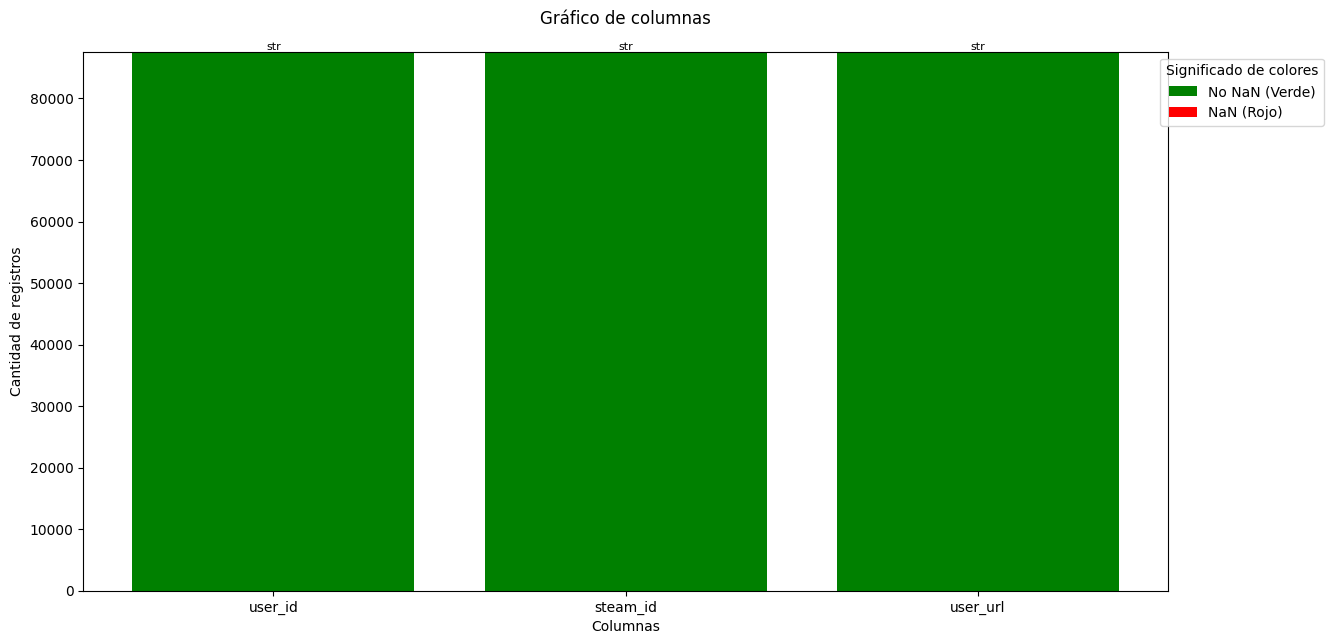

In [45]:
funciones.plot_df_info(user_info_df)

In [ ]:
'''
Nota: nos falta pulir, rehacer todo el codigo incluyendo los cambios que hicimos ultimos, en el orden que correspondan, por ej
deshacernos de la columna items_count al principio, y manejar los nombres de los juegos a ver si no hay errores de escritura
'''